In [26]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from pathlib import Path
import json


In [27]:
# baseDir = r'/u/home/l/laxmanda/project-hvburton/autoWoodSDA/'
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/woodSDA/autoWoodSDA_public'


In [28]:
buildingID = 'MFD6B'
resultRootDir = os.path.join(baseDir, 'Results', buildingID)

df_edp = pd.read_csv(os.path.join(resultRootDir, f'EDP_Profile_{buildingID}.csv'))
df_loss = pd.read_csv(os.path.join(resultRootDir, f'Loss_pelicun_{buildingID}.csv'), index_col=0)
df_recovery = pd.read_csv(os.path.join(resultRootDir, f'Loss_ATC_RecoveryTimes_{buildingID}.csv'))

In [29]:
df_loss.tail()

,BuildingID,Replacement_Cost,Mean_Repair_Cost,Median_Repair_Cost,RepairCost_10th_percentile,RepairCost_25th_percentile,RepairCost_75th_percentile,RepairCost_90th_percentile,RepairCost_std,Hazard_level,SA(T1=0.3s),Max SDR,Max PFA,Max RDR,Max PGA
8,MFD6B,7133184,8.816173e+05,7.223120e+05,476076.083442,586961.444546,8.845288e+05,1.061907e+06,9.750179e+05,9,1.5,0.200003,2.680923,0.198851,1.710697
9,MFD6B,7133184,8.857316e+05,7.670628e+05,495263.086431,617431.872907,9.416933e+05,1.142727e+06,8.190281e+05,10,1.8,0.339119,2.466981,0.339119,1.600707
10,MFD6B,7133184,9.661197e+05,8.289017e+05,550440.036697,667495.393314,1.014414e+06,1.221657e+06,8.899281e+05,11,2.0,0.258689,2.703752,0.258689,1.523244
11,MFD6B,7133184,9.478489e+05,8.441540e+05,569008.657041,695808.304692,1.019561e+06,1.225193e+06,7.528617e+05,12,2.5,0.175096,2.982721,0.175096,1.814860
12,MFD6B,7133184,1.416261e+06,1.001703e+06,655271.270186,803075.918523,1.256749e+06,1.594761e+06,1.565429e+06,13,3.0,0.267213,3.200243,0.267213,2.734705


<AxesSubplot:xlabel='SA(T1=0.3s)', ylabel='Median_Repair_Cost'>

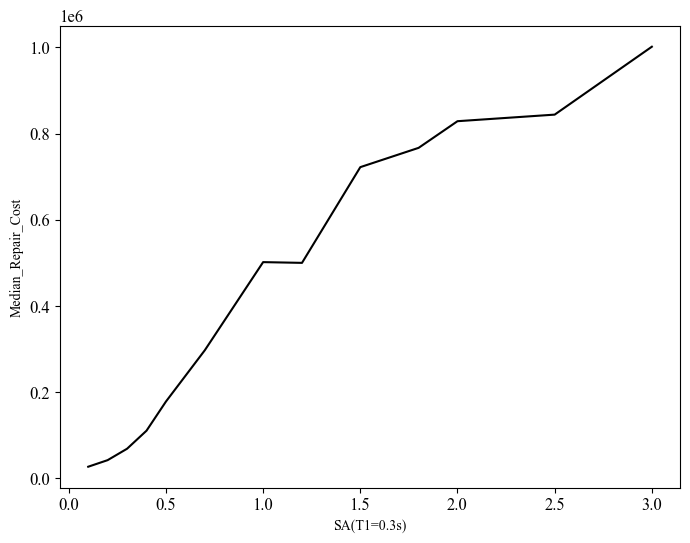

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sns.lineplot(data=df_loss, x='SA(T1=0.3s)', y= 'Median_Repair_Cost',
                errorbar=None, hue=None,
                markers=False, dashes=False, lw = 1.5, estimator=None, color='black',
                ax=ax)

In [31]:
df_recovery.head()

,Unnamed: 0,BuildingID,Mean Functional Recovery,Std Functional Recovery,Median Functional Recovery,25th percentile FR,75th percentile FR,90th percentile FR,Mean Reoccupancy,Std Reoccupancy,Median Reoccupancy,25th percentile Reoccupancy,75th percentile Reoccupancy,90th percentile Reoccupancy,Hazard_level,SA(T1=0.3s)
0,0,MFD6B,1.254117,18.332597,0.0,0.0,0.0,0.0,1.163427,18.321198,0.0,0.0,0.0,0.0,1,0.1
1,1,MFD6B,3.252250,26.531594,0.0,0.0,0.0,8.0,2.630940,26.164208,0.0,0.0,0.0,7.0,2,0.2
2,2,MFD6B,14.584263,67.781137,0.0,0.0,8.0,12.0,9.693223,64.406683,0.0,0.0,6.0,10.0,3,0.3
3,3,MFD6B,29.632333,111.445603,6.0,0.0,10.0,17.0,23.490197,109.547210,0.0,0.0,8.0,12.0,4,0.4
4,4,MFD6B,42.567693,128.505932,8.0,4.0,12.0,83.1,33.576530,126.744681,6.0,0.0,10.0,14.0,5,0.5


<AxesSubplot:xlabel='SA(T1=0.3s)', ylabel='Median Functional Recovery'>

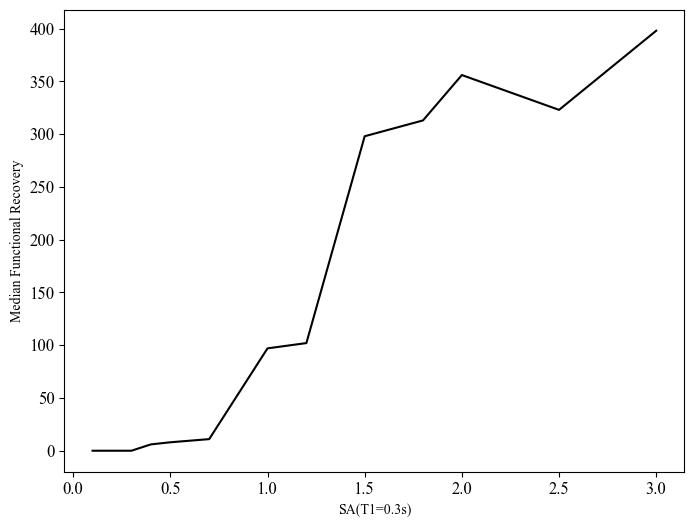

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sns.lineplot(data=df_recovery, x='SA(T1=0.3s)', y= 'Median Functional Recovery',
                errorbar=None, hue=None,
                markers=False, dashes=False, lw = 1.5, estimator=None, color='black',
                ax=ax)

<AxesSubplot:xlabel='SA(T1=0.3s)', ylabel='Median Reoccupancy'>

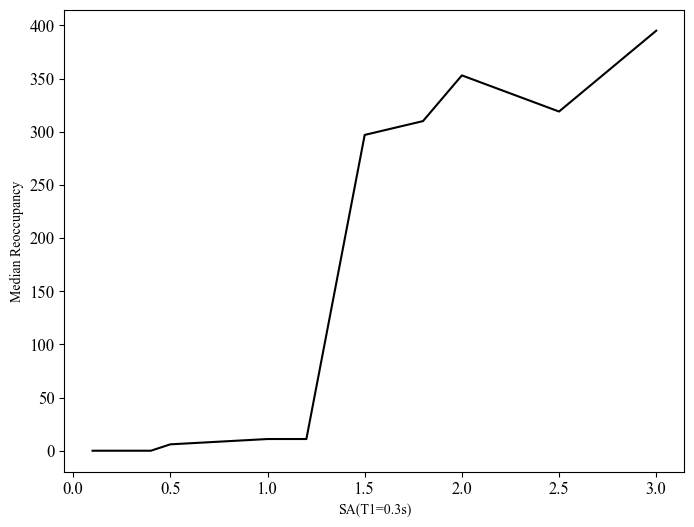

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sns.lineplot(data=df_recovery, x='SA(T1=0.3s)', y= 'Median Reoccupancy',
                errorbar=None, hue=None,
                markers=False, dashes=False, lw = 1.5, estimator=None, color='black',
                ax=ax)

In [16]:
def smooth_list(list_of_old_values):
    """
    """
    list_of_new_values = []

    for i in range(len(list_of_old_values)):

        # For the first value
        if i == 0:
            # if the current loss/downtime value is higher than the next loss/downtime value,
            # take the average of the current and next loss/downtime value
            current_val = list_of_old_values[i]
            next_val = list_of_old_values[i+1]
            if (current_val > next_val):
                list_of_new_values.append(
                    round(np.average(list_of_old_values[i:i+2])))
            else:
                list_of_new_values.append(list_of_old_values[i])

        # For all values except the first and last 2
        elif i < (len(list_of_old_values)-2):
            # if the current loss/downtime value is greater than the next loss/downtime value,
            # take the average of the previous, current, and next loss/downtime value.
            current_val = list_of_old_values[i]
            previous_val = list_of_new_values[i-1]  # from new curve
            next_val = list_of_old_values[i+1]      # from old curve
            if (current_val < previous_val):
                list_of_new_values.append(
                    round(np.average(list_of_old_values[i-1:i+2]))) #rounds to int.. careful if using this function with vals <1 -MA
            elif current_val > next_val:
                list_of_new_values.append(
                    round(np.average(list_of_old_values[i-1:i+2])))
            else:
                list_of_new_values.append(list_of_old_values[i])

        # For the last value
        else:
            # if the current loss/downtime value is lower than the previous loss/downtime value,
            # take the average of the previous and current loss/downtime value.
            current_val = list_of_old_values[i]
            previous_val = list_of_new_values[i-1]      #updated to say 'new' -MA 5/2023
            if (current_val < previous_val):
                list_of_new_values.append(
                    round(np.average(list_of_old_values[i-1:i+1])))
            else:
                list_of_new_values.append(list_of_old_values[i])

        # Perform a check. Current value can't be less than previous value
        if i > 0:
            if list_of_new_values[i] < list_of_new_values[i-1]:
                # set current value equal to previous value
                list_of_new_values[i] = list_of_new_values[i-1]

    return list_of_new_values



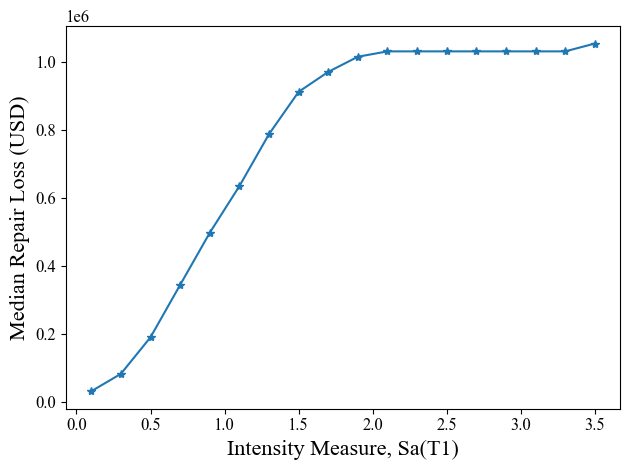

In [20]:
plt.plot(df_loss['SA(T1=0.3s)'].values, smooth_list(df_loss['Median_Repair_Cost'].values), marker='*')
plt.xlabel('Intensity Measure, Sa(T1)', fontsize=16)
plt.ylabel('Median Repair Loss (USD)', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(resultRootDir, f'Loss_curve_{buildingID}.png'))

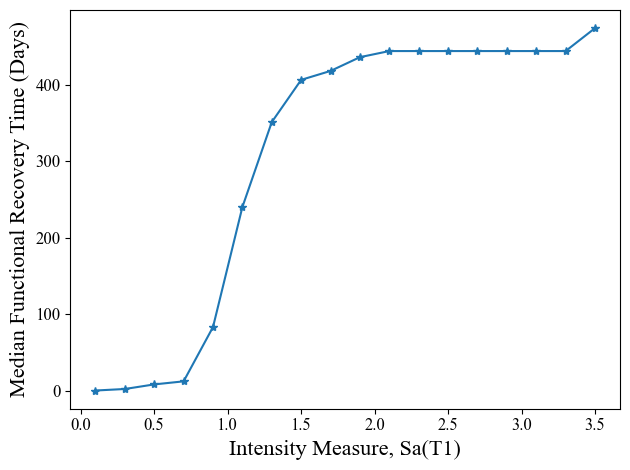

In [21]:
plt.plot(df_recovery['SA(T1=0.3s)'].values, smooth_list(df_recovery['Median Functional Recovery'].values), 
         marker='*')
plt.xlabel('Intensity Measure, Sa(T1)', fontsize=16)
plt.ylabel('Median Functional Recovery Time (Days)', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(resultRootDir, f'funcRecovery_curve_{buildingID}.png'))